# Imports
We'll start by importing the packages we used in the exercises

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy import create_engine
from scipy import stats
import numpy as np
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import mstats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
import json

# Data Preprocessing
* Load the data from SQL
* Clean the data to fix any errors or inconsistencies
* Encode the statistical data type 
* Impute any missing values

#### Load the data from SQL

In [3]:
host = "mysql-1.cda.hhs.se"
username = "7313"
password = "data"
schema = "StockholmHousingMarket"
connection_string = "mysql+pymysql://{}:{}@{}/{}".format(username, password, host, schema)
connection = create_engine(connection_string)

sql_query_a = """
SELECT *
FROM Apartment
"""
df = pd.read_sql_query(sql_query_a, connection)

sql_query_b = "SELECT * FROM AnnualReport"
df_report = pd.read_sql_query(sql_query_b, connection)

#### Clean the data


Clean the data in the AnnualReport by grouping it according to different org_number values

In [4]:
def mode_or_mean(x):
    if x.dtype == 'object':
        return x.mode()[0] if not x.mode().empty else None
    else:
        return x.mean()
    
ar_df = df_report.groupby('org_number').agg(mode_or_mean)

Merge Apartment and AnnualReport as df2 by org_number

In [5]:
df2 = pd.merge(df, ar_df, left_on='housing_association_org_number', right_on='org_number', how='left')

Clean the data in df2

In [6]:
# set id as index
df2.set_index('id', inplace=True)
df2.sort_index(inplace=True)
df2 = df2.drop(['fiscal_year'], axis=1)
# Convert 'sell_date' to datetime
df2['sell_date'] = pd.to_datetime(df2['sell_date'])
# Extract year and month
df2['year'] = df2['sell_date'].dt.year
df2['month'] = df2['sell_date'].dt.month
df2 = df2.drop('sell_date', axis=1)
df2['energy_class'] = df2['energy_class'].replace({'A': '1', 'B': '2','C': '3','D': '4','E': '5','F': '6','G': '7'})
for i in ['housing_coop_id', 'plot_is_leased','floor','postcode','year','month']:
    df2[i] = df2[i].astype('object')

Split data into train and test

In [7]:
df_train = df2[df2['sell_price'].notna()]
df_test = df2[df2['sell_price'].isna()]
y_train = df_train['sell_price']
X_train = df_train.drop(['sell_price'], axis=1)
y_test = df_test['sell_price']
X_test = df_test.drop(['sell_price'], axis=1)

In [8]:
# indentify the categorical and numerical columns by checking the df.info()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174658 entries, 0000e3917662f30720d1801912f45349 to ffffde3cb437b8ec8b02bc88000c8613
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   rooms                           174278 non-null  float64
 1   legal_district                  173648 non-null  object 
 2   postcode                        174658 non-null  object 
 3   locality                        162751 non-null  object 
 4   street_name                     174289 non-null  object 
 5   object_type                     174658 non-null  object 
 6   street_address                  174658 non-null  object 
 7   brokers_description             174658 non-null  object 
 8   latitude                        174658 non-null  float64
 9   longitude                       174658 non-null  float64
 10  energy_class                    61154 non-null   object 
 11  has_solar_panels          

In [9]:
# get the unique values of each of the columns whose Dtype is object
cat_cols = X_train.select_dtypes(include=['object']).columns.values.tolist()

for col in cat_cols:
    print("For categorical column {}, there are {} unique values ".format(col, X_train[col].nunique()))

For categorical column legal_district, there are 21 unique values 
For categorical column postcode, there are 682 unique values 
For categorical column locality, there are 37 unique values 
For categorical column street_name, there are 1838 unique values 
For categorical column object_type, there are 3 unique values 
For categorical column street_address, there are 20645 unique values 
For categorical column brokers_description, there are 1179 unique values 
For categorical column energy_class, there are 7 unique values 
For categorical column floor, there are 47 unique values 
For categorical column housing_association_org_number, there are 5250 unique values 
For categorical column housing_coop_id, there are 5250 unique values 
For categorical column association_tax_liability, there are 3 unique values 
For categorical column plot_is_leased, there are 11 unique values 
For categorical column year, there are 11 unique values 
For categorical column month, there are 12 unique values 


In [10]:
# the columns with too many unique values are not useful for our analysis, so we drop them, and update the cat_cols
X_train = X_train.drop(['street_address', 'brokers_description','housing_coop_id'], axis=1)
X_test = X_test.drop(['street_address', 'brokers_description','housing_coop_id'], axis=1)
cat_cols = X_train.select_dtypes(include=['object']).columns.values.tolist()
num_cols = X_train.columns.difference(cat_cols).values.tolist()

check missing values and drop columns

In [11]:
# drop columns with number of missing values more than 30% of the total number of rows
to_drop = []
for col in num_cols:
    print("For numerical column {}, there are {} missing values ".format(col, X_train[col].isna().sum()))
    if X_train[col].isna().sum() > 0.3 * X_train.shape[0]:
        to_drop.append(col)

X_train = X_train.drop(to_drop, axis=1)

For numerical column additional_area, there are 171735 missing values 
For numerical column agency_id, there are 155675 missing values 
For numerical column asking_price, there are 157917 missing values 
For numerical column has_balcony, there are 173609 missing values 
For numerical column has_fireplace, there are 173609 missing values 
For numerical column has_patio, there are 173609 missing values 
For numerical column has_solar_panels, there are 173686 missing values 
For numerical column height, there are 173651 missing values 
For numerical column is_new_construction, there are 173609 missing values 
For numerical column latitude, there are 0 missing values 
For numerical column living_area, there are 554 missing values 
For numerical column long_term_debt_other, there are 6849 missing values 
For numerical column long_term_real_estate_debt, there are 4061 missing values 
For numerical column longitude, there are 0 missing values 
For numerical column number_of_rental_units, ther

#### Encode the categorical columns

In [12]:
# push the categorical columns' values to binary_labels
for column in cat_cols:
    # Fill missing values
    X_train[column].fillna('unknown', inplace=True)
    X_train[column] = X_train[column].astype(str)
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(X_train[column])

    # Convert numeric labels to binary strings
    max_length = len(bin(max(numeric_labels))[2:])
    binary_labels = [format(label, f'0{max_length}b') for label in numeric_labels]
    # Replace the original column with binary labels
    X_train[column] = binary_labels

#### Impute any missing values

In [13]:
# for the numerical columns with missing values, fill the missing values with the mean of the column of the group, groupby housing_association_org_number;
cat_cols = X_train.select_dtypes(include=['object']).columns.values.tolist()
num_cols = X_train.columns.difference(cat_cols).values.tolist()
for column in num_cols:
    mean_per_association = X_train.groupby('housing_association_org_number')[column].transform(
        lambda x: x.mean() if not x.empty else None)
    X_train[column] = X_train[column].fillna(mean_per_association)

# if there is no mode. fill the nan with the next value
for column in num_cols:
    X_train[column] = X_train[column].fillna(method='bfill')

/var/folders/27/74d_ssyx3yv8f9xjplgq6_lm0000gn/T/ipykernel_58268/1118127604.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train[column] = X_train[column].fillna(method='bfill')


Drop the same columns on X-test and fill NA, binary categories

In [14]:
X_test = X_test.drop(to_drop, axis=1)
for column in cat_cols:
    # Fill missing values
    X_test[column].fillna('unknown', inplace=True)
    X_test[column] = X_test[column].astype(str)
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(X_test[column])

    # Convert numeric labels to binary strings
    max_length = len(bin(max(numeric_labels))[2:])
    binary_labels = [format(label, f'0{max_length}b') for label in numeric_labels]
    # Replace the original column with binary labels
    X_test[column] = binary_labels

In [16]:
# for the numerical columns with missing values, fill the missing values with the mean of the column of the group, groupby housing_association_org_number
cat_cols = X_test.select_dtypes(include=['object']).columns.values.tolist()
num_cols = X_test.columns.difference(cat_cols).values.tolist()
for column in num_cols:
    mean_per_association = X_test.groupby('housing_association_org_number')[column].transform(
        lambda x: x.mean() if not x.empty else None)
    X_test[column] = X_test[column].fillna(mean_per_association)

# if there is no mode. fill the nan with the following value
for column in num_cols:
    X_test[column] = X_test[column].fillna(method='bfill')

/var/folders/27/74d_ssyx3yv8f9xjplgq6_lm0000gn/T/ipykernel_58268/2750158732.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test[column] = X_test[column].fillna(method='bfill')


# Establish Baseline - OLS

In [17]:
X_train, X_val, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

Scale the numerical columns

In [18]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
y_train = y_train.apply(np.log)
y_val = y_cal.apply(np.log)

In [19]:
model_performance = {}
train_test_performance = {}

def adjusted_r2(r_squared, n, p):
    return 1 - (1-r_squared) * (n-1)/(n-p-1)

def fit_and_evaluate(model, modelName, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    adj_r2 = adjusted_r2(r2, x_test.shape[0], x_test.shape[1])
    model_performance[modelName] = [mse, rmse, r2, adj_r2]
    print("MSE: {:.4f}, RMSE: {:.4f}, R²: {:.4f}, Adj. R²: {:.4f}".format(mse, rmse, r2, adj_r2))
    # print train, test error
    train_error = mean_squared_error(y_train, model.predict(x_train))
    train_r2 = r2_score(y_train, model.predict(x_train))
    train_test_performance[modelName+'_train'] = [train_error, train_r2]
    train_test_performance[modelName+'_val'] = [mse, r2]
    print("Train error is: {:.4f}".format(train_error))
    print("Eval error is: {:.4f}".format(mse))
    print("Train R2 is: {:.4f}".format(train_r2))
    print("Eval R2 is: {:.4f}".format(r2))
    return

# fit on Linear Regression, Lasso, Ridge, Random Forest
ols = LinearRegression()

# fit the models
fit_and_evaluate(ols, 'ols', X_train, y_train, X_val, y_val)

# show the dictionary of model performance in a dataframe
model_performance_df = pd.DataFrame(model_performance, index=['MSE', 'RMSE', 'R2', 'Adj. R2'])
print(model_performance_df)

MSE: 0.0576, RMSE: 0.2400, R²: 0.7663, Adj. R²: 0.7662
Train error is: 0.0573
Eval error is: 0.0576
Train R2 is: 0.7664
Eval R2 is: 0.7663
              ols
MSE      0.057604
RMSE     0.240008
R2       0.766308
Adj. R2  0.766164


# feature selection
1. check correlation
2. Feature Utility Scores
3. stepwise selection

##### check correlation

In [20]:
# check the correlation between columns
corr = X_train.corr()

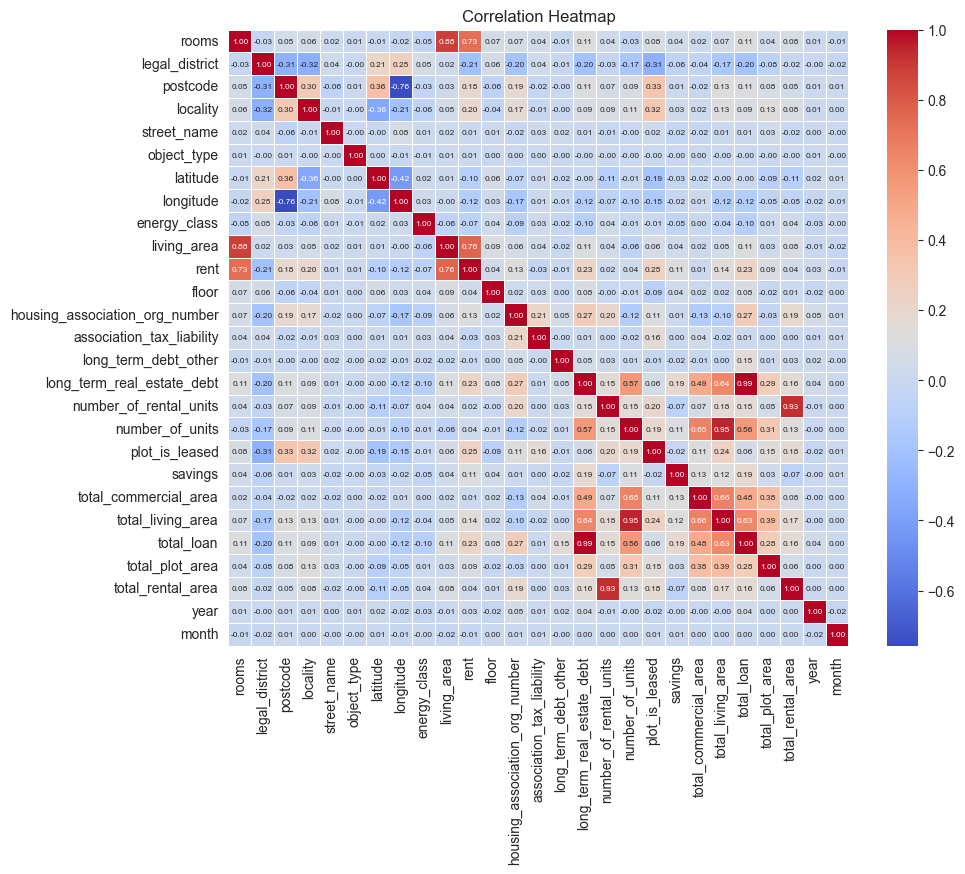

In [27]:
# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,annot_kws={"size": 6})
plt.title("Correlation Heatmap")
plt.show()

Avoid multicollinearity in model

In [28]:
threshold = 0.9
high_corr_var = [(column, index) for column in corr.columns for index in corr.columns if column != index and corr.loc[column, index] > threshold]
corr_to_drop = set(x[1] for x in high_corr_var)

In [29]:
X_train = X_train.drop(columns=corr_to_drop)
X_test = X_test.drop(columns=corr_to_drop)
X_val = X_val.drop(columns=corr_to_drop)

##### Feature Utility Scores

In [30]:
mi = mutual_info_regression(X_train, y_train)
mi_df = pd.DataFrame(mi, index=X_train.columns, columns=['Mutual Information'])
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

low_mi_features = mi_df[mi_df['Mutual Information'] < 0.05].index
# drop 'total_plot_area', 'floor', 'long_term_debt_other', 'energy_class','association_tax_liability', 'object_type'

In [31]:
X_train = X_train.drop(columns=low_mi_features)
X_test = X_test.drop(columns=low_mi_features)
X_val = X_val.drop(columns=low_mi_features)

##### stepwise selection

In [33]:
corr_t = X_train.corrwith(y_train)
corr_t = corr_t.to_frame(name='Correlation')
corr_t.sort_values(by='Correlation', ascending=False, inplace=True)
print(corr_t)

# Define the columns to consider for stepwise selection
columns = X_train.columns.tolist()

                                Correlation
living_area                        0.642482
rooms                              0.566535
legal_district                     0.359900
longitude                          0.321719
rent                               0.296247
year                               0.181179
latitude                           0.155530
street_name                        0.038445
savings                           -0.002579
total_commercial_area             -0.040865
housing_association_org_number    -0.055714
locality                          -0.302986
plot_is_leased                    -0.308871
postcode                          -0.358184


In [34]:
# 2. Perform stepwise selection
selected_columns = []
remaining_columns = columns.copy()

while len(remaining_columns) > 0:
    best_pvalue = float('inf')
    best_column = None
    
    for column in remaining_columns:
        # Add the selected columns to the existing ones
        X = X_train[selected_columns + [column]]
        
        # Fit the model and calculate the p-value
        model = LinearRegression()
        selector = SelectKBest(score_func=f_regression, k=1)
        X_new = selector.fit_transform(X, y_train)
        pvalue = selector.pvalues_[0]
        
        # Update the best column if necessary
        if pvalue < best_pvalue:
            best_pvalue = pvalue
            best_column = column
    
    # Add the best column to the selected columns
    selected_columns.append(best_column)
    remaining_columns.remove(best_column)

# Print the selected columns
print("Selected columns:", selected_columns)
# Result: no feature is deleted


Selected columns: ['rooms', 'legal_district', 'postcode', 'locality', 'street_name', 'latitude', 'longitude', 'living_area', 'rent', 'housing_association_org_number', 'plot_is_leased', 'savings', 'total_commercial_area', 'year']


#### Model Selection
1. Lasso
2. Ridge
3. Random Forest

In [35]:
# 1. Lasso and 2. Ridge
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)

# fit the models
fit_and_evaluate(lasso, 'lasso', X_train, y_train, X_val, y_val)
fit_and_evaluate(ridge, 'ridge', X_train, y_train, X_val, y_val)

MSE: 0.0825, RMSE: 0.2873, R²: 0.6652, Adj. R²: 0.6651
Train error is: 0.0825
Eval error is: 0.0825
Train R2 is: 0.6635
Eval R2 is: 0.6652


/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.75296e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


MSE: 0.0611, RMSE: 0.2472, R²: 0.7520, Adj. R²: 0.7520
Train error is: 0.0611
Eval error is: 0.0611
Train R2 is: 0.7510
Eval R2 is: 0.7520


In [37]:
# 3. Random Forest
rf = RandomForestRegressor(n_estimators=100)
fit_and_evaluate(rf, 'rf', X_train, y_train, X_val, y_val)
# show the dictionary of model performance in a dataframe
model_performance_df = pd.DataFrame(model_performance, index=['MSE', 'RMSE', 'R2', 'Adj. R2'])
print(model_performance_df)

# put the train test error, score of lasso, ridge and ols in a dataframe
train_test_performance_df = pd.DataFrame(train_test_performance, index=['MSE', 'R2'])
print(train_test_performance_df)

MSE: 0.0127, RMSE: 0.1125, R²: 0.9487, Adj. R²: 0.9487
Train error is: 0.0019
Eval error is: 0.0127
Train R2 is: 0.9921
Eval R2 is: 0.9487
              ols     lasso     ridge        rf
MSE      0.057604  0.082520  0.061123  0.012653
RMSE     0.240008  0.287264  0.247231  0.112484
R2       0.766308  0.665224  0.752031  0.948670
Adj. R2  0.766164  0.665116  0.751952  0.948653
     ols_train   ols_val  lasso_train  lasso_val  ridge_train  ridge_val  \
MSE   0.057297  0.057604     0.082532   0.082520     0.061066   0.061123   
R2    0.766378  0.766308     0.663487   0.665224     0.751011   0.752031   

     rf_train    rf_val  
MSE  0.001931  0.012653  
R2   0.992126  0.948670  


#### FINAL MODEL: Random Forest

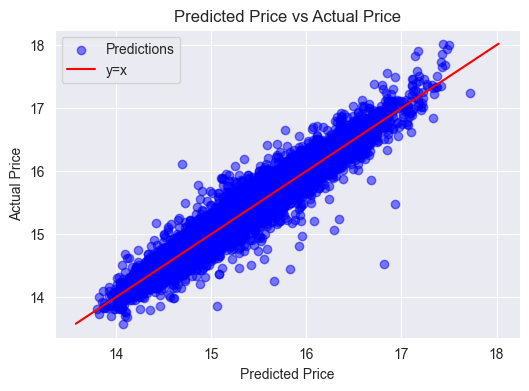

In [38]:
# fit the model on the whole training data and predict on the test data
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
predictions_val = rf.predict(X_val)

# Plot the predictions and the actual values using different colors, add a line of y=x 
plt.figure(figsize=(6, 4))
plt.scatter(predictions_val, y_val, color='blue', alpha=0.5, label='Predictions')
plt.plot(np.linspace(np.min(y_val), np.max(y_val), 100), np.linspace(np.min(y_val), np.max(y_val), 100), color='red', label='y=x')
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Predicted Price vs Actual Price")
plt.legend()
plt.show()
# the plot indicates a clear trend of non-linear relationship
predictions = rf.predict(X_test)
predictions_best = np.exp(predictions)

# Improve the model by cross_validation and tuning the hyperparameters
1. Cross validation
2. Grid search

##### Cross validation

In [39]:
from sklearn.model_selection import cross_val_score
ols = LinearRegression()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)
rf = RandomForestRegressor(n_estimators=100)

X_train_cv = pd.concat([X_train, X_val])
y_train_cv = pd.concat([y_train, y_val])
for model in [ols, lasso, ridge, rf]:
    scores = cross_val_score(model, X_train_cv, y_train_cv, cv=3, scoring='neg_mean_squared_error')
    print(f"Training {model.__class__.__name__}...")
    print(f"Average RMSE: {np.mean(np.sqrt(-scores))}")
    print("Training completed.\n")

Training LinearRegression...
Average RMSE: 0.24719456204957355
Training completed.
Training Lasso...
Average RMSE: 0.2872179864530257
Training completed.


/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.63051e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.83543e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.73612e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training Ridge...
Average RMSE: 0.24719456104065188
Training completed.
Training RandomForestRegressor...
Average RMSE: 0.11300422004486486
Training completed.


# Hyperparameter Tuning
##### GridSearch
Ridge and RF have the best results, so we perform grid search on Ridge

In [40]:
from sklearn.model_selection import GridSearchCV
# define the grid
grid = {'alpha': [0.01, 0.1, 1, 10, 30, 45, 50, 60]}
# instantiate the model
ridge = Ridge()
# instantiate the grid search model
ridge_cv = GridSearchCV(ridge, grid, cv=3)
# fit the grid search to the data
ridge_cv.fit(X_train_cv, y_train_cv)
# print the tuned parameters and score
print("Tuned Ridge Parameters: {}".format(ridge_cv.best_params_))
scores_lasso = cross_val_score(ridge_cv, X_train_cv, y_train_cv, cv=3, scoring='neg_mean_squared_error')
print("Best score is {}".format(ridge_cv.best_score_))
# Tuned ridge Parameters: {'alpha': 50}

/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.63048e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.8354e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.73608e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.6482e-25): result may not be accurate.
  retur

Tuned Ridge Parameters: {'alpha': 50}


/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.74728e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [42]:
# grid search on random forest
# define the grid
grid = {'n_estimators': [100, 200, 300]}
# instantiate the model
rf = RandomForestRegressor()
# instantiate the grid search model
rf_cv = GridSearchCV(rf, grid, cv=3)
# fit the grid search to the data
rf_cv.fit(X_train_cv, y_train_cv)
# print the tuned parameters and score
print("Tuned RF Parameters: {}".format(rf_cv.best_params_))
# scores_rf = cross_val_score(rf_cv, X_train_cv, y_train_cv, cv=3, scoring='neg_mean_squared_error')
# print("Best score is {}".format(rf_cv.best_score_))
# Tuned RF Parameters: {'n_estimators': 300}

Tuned RF Parameters: {'n_estimators': 300}


##### Final model

In [43]:
ridge = Ridge(alpha=50)
rf = RandomForestRegressor(n_estimators=300)
fit_and_evaluate(ridge, 'ridge_tuning', X_train, y_train, X_val, y_val)
fit_and_evaluate(rf, 'rf_tuning', X_train, y_train, X_val, y_val)
# show the dictionary of model performance in a dataframe
model_performance_df = pd.DataFrame(model_performance, index=['MSE', 'RMSE', 'R2', 'Adj. R2'])
print(model_performance_df)

/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.76886e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


MSE: 0.0611, RMSE: 0.2472, R²: 0.7520, Adj. R²: 0.7520
Train error is: 0.0611
Eval error is: 0.0611
Train R2 is: 0.7510
Eval R2 is: 0.7520
MSE: 0.0126, RMSE: 0.1123, R²: 0.9489, Adj. R²: 0.9489
Train error is: 0.0019
Eval error is: 0.0126
Train R2 is: 0.9923
Eval R2 is: 0.9489
              ols     lasso     ridge        rf  ridge_tuning  rf_tuning
MSE      0.057604  0.082520  0.061123  0.012653      0.061123   0.012602
RMSE     0.240008  0.287264  0.247231  0.112484      0.247230   0.112258
R2       0.766308  0.665224  0.752031  0.948670      0.752032   0.948876
Adj. R2  0.766164  0.665116  0.751952  0.948653      0.751952   0.948859


#### Final Model and Prediction

In [45]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_train, y_train)
predict_y = rf.predict(X_test)

Evaluate predictive power of each features in final model

In [53]:
mi_final = mutual_info_regression(X_test, predict_y)
mi_df_final = pd.DataFrame(mi_final, index=X_test.columns, columns=['Mutual Information'])
mi_df_final = mi_df_final.sort_values(by='Mutual Information', ascending=False)
mi_df_final

,Mutual Information
living_area,0.790794
latitude,0.460596
longitude,0.381275
postcode,0.334102
rooms,0.317102
legal_district,0.269179
locality,0.250331
rent,0.207925
total_commercial_area,0.163029
savings,0.140806


#### Output

In [55]:
output = [{"id": idx, "sell_price": np.exp(price)} for idx, price in zip(X_test.index, predict_y)]

filename = 'x.json'
with open(filename, 'w') as file:
    json.dump(output, file, indent=4)